In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Exercise 1: Feature points detectors

## a) Hessian matrix

In [2]:
def gauss(sigma, size = -1, rng = False):
	if size == -1:
		size = 6 * sigma + 1
	kern = np.arange(-size // 2 + size % 2, size // 2 + size % 2)
	kern = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(kern ** 2) / (2 * (sigma ** 2)))
	kern /= np.sum(kern)

	if rng == True:
		return kern, np.arange(-size // 2 + size % 2, size // 2 + size % 2)
	else:
		return kern

def gaussdx(sigma, size = -1, rng = False):
	if size == -1:
		size = 6 * sigma + 1
	kern = np.arange(-size // 2 + size % 2, size // 2 + size % 2)
	kern = -(1 / (np.sqrt(2 * np.pi) * sigma ** 3)) * kern * np.exp(-(kern ** 2) / (2 * (sigma ** 2)))
	kern /= np.sum(np.abs(kern))

	if rng == True:
		return kern, np.arange(-size // 2 + size % 2, size // 2 + size % 2)
	else:
		return kern

def partial_derivatives(img, sigma):
	gkern = np.array([gauss(sigma)])
	dkern = np.array([gaussdx(sigma)])

	Ix = np.copy(img).astype(np.float32)
	Iy = np.copy(img).astype(np.float32)
	
	Ix = cv2.filter2D(Ix, -1, gkern)
	Ix = cv2.filter2D(Ix, -1, np.fliplr(dkern))
	Iy = cv2.filter2D(Iy, -1, gkern.T)
	Iy = cv2.filter2D(Iy, -1, np.flipud(dkern.T))

	Ixx = np.copy(Ix).astype(np.float32)
	Ixy = np.copy(Ix).astype(np.float32)
	Iyy = np.copy(Iy).astype(np.float32)

	Ixx = cv2.filter2D(Ixx, -1, gkern)
	Ixx = cv2.filter2D(Ixx, -1, np.fliplr(dkern))
	Ixy = cv2.filter2D(Ixy, -1, gkern.T)
	Ixy = cv2.filter2D(Ixy, -1, np.flipud(dkern.T))
	Iyy = cv2.filter2D(Iyy, -1, gkern.T)
	Iyy = cv2.filter2D(Iyy, -1, np.flipud(dkern.T))

	return Ix, Iy, Ixx, Ixy, Iyy

def gradient_magnitude(ix, iy):
	ix = ix.astype(np.float32)
	iy = iy.astype(np.float32)
	magnitude = np.sqrt(ix ** 2 + iy ** 2)
	angle = np.arctan2(ix, iy)
	return magnitude, angle

def nms(himg):
	img = np.pad(np.copy(himg), 1)
	pimg = np.copy(img)
	h, w = pimg.shape

	for y in range(1, h-1):
		for x in range(1, w-1):
			sect = np.delete(pimg[y-1:y+2,x-1:x+2], 4)
			if img[y,x] <= np.max(sect):
				img[y,x] = 0

	return img[1:-1,1:-1]

In [3]:
def hessian_points(img, sigma, threshold):
	_, _, Ixx, Ixy, Iyy = partial_derivatives(img, sigma)
	h_det = (Ixx * Iyy - Ixy ** 2)
	# h_det = sigma ** 4 * (Ixx * Iyy - Ixy ** 2)

	return h_det, np.argwhere(nms(h_det) > threshold)

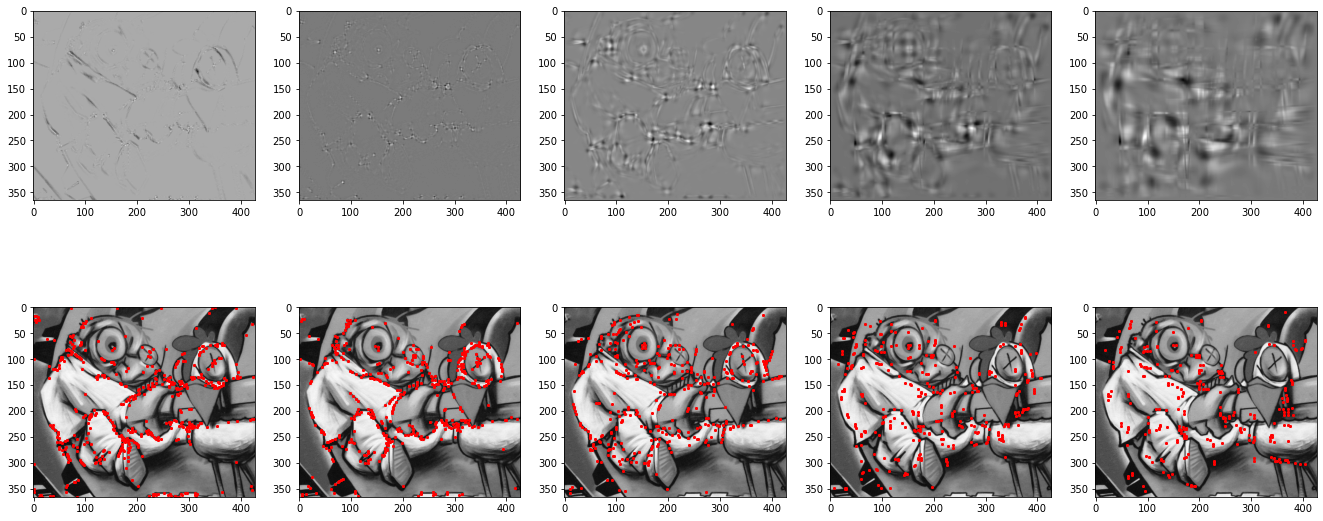

In [4]:
img_points = cv2.cvtColor(cv2.imread('data/test_points.jpg'), cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(23,10))
for i, sigma in enumerate([0.5, 1, 3, 6, 9]):
	det, points = hessian_points(img_points, sigma, 100)
	plt.subplot(2, 5, i+1)
	plt.imshow(det, cmap='gray')
	plt.subplot(2 ,5 ,i+6)
	plt.imshow(img_points, cmap='gray')
	plt.scatter(points[:,1], points[:,0], s = 5, c = 'red', marker = 'x')
plt.show()

## b) Harris feature detection

In [5]:
def convolve(img, kernel):
	img = np.copy(img)
	img = cv2.filter2D(img, -1, kernel)
	img = cv2.filter2D(img, -1, kernel.T)
	return img

def harris_feature_detection(img, sigma, threshold):
	Ix, Iy, _, Ixy, _ = partial_derivatives(img, sigma)
	gkern = np.array([gauss(1.6 * sigma)])
	alpha = 0.06

	cix = convolve(Ix ** 2, gkern) * sigma ** 2
	ciy = convolve(Iy ** 2, gkern) * sigma ** 2
	cixy = convolve(Ix * Iy, gkern) * sigma ** 2

	h_det = cix * ciy - cixy ** 2
	h_trace = cix + ciy
	res = h_det - alpha * h_trace ** 2

	return res, np.argwhere(nms(res) > threshold)

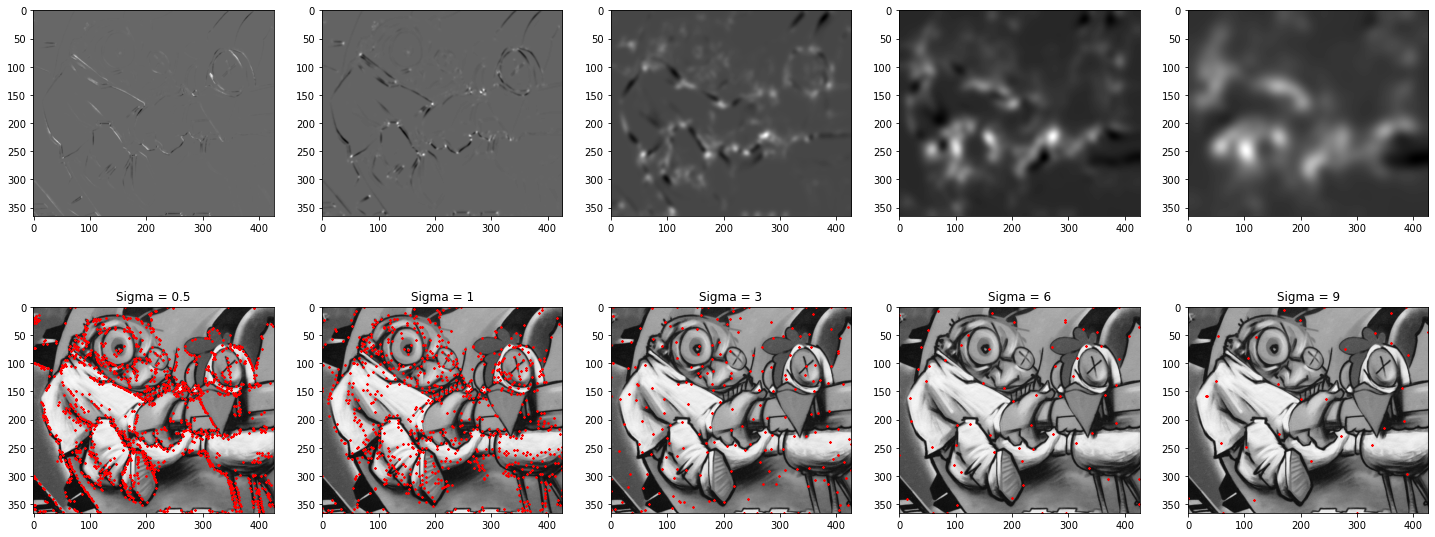

In [6]:
plt.figure(figsize=(25, 10))
for i, sigma in enumerate([0.5, 1, 3, 6, 9]):
	res, points = harris_feature_detection(img_points, sigma, 100)
	plt.subplot(2, 5, i+1)
	plt.imshow(res, cmap='gray')
	plt.subplot(2 ,5 ,i+6)
	plt.title(f"Sigma = {sigma}")
	plt.imshow(img_points, cmap='gray')
	plt.scatter(points[:,1], points[:,0], s = 3, c = 'red', marker = 'x')

# Exercise 2: Matching local regions

## a) Function find_correspondances

In [7]:
def simple_descriptors(I, pts, bins=16, radius=40, sigma=1):
	g = gauss(sigma)
	d = gaussdx(sigma)

	Ix = cv2.filter2D(I, cv2.CV_32F, g.T)
	Ix = cv2.filter2D(Ix, cv2.CV_32F, d)
	Iy = cv2.filter2D(I, cv2.CV_32F, g)
	Iy = cv2.filter2D(Iy, cv2.CV_32F, d.T)

	Ixx = cv2.filter2D(Ix, cv2.CV_32F, g.T)
	Ixx = cv2.filter2D(Ixx, cv2.CV_32F, d)
	Iyy = cv2.filter2D(Iy, cv2.CV_32F, g)
	Iyy = cv2.filter2D(Iyy, cv2.CV_32F, d.T)

	mag = np.sqrt(Ix**2+Iy**2)
	mag = np.floor(mag*((bins-1)/np.max(mag)))

	feat = Ixx+Iyy
	feat += abs(np.min(feat))
	feat = np.floor(feat*((bins-1)/np.max(feat)))

	desc = []

	for y,x in pts:
		minx = max(x-radius, 0)
		maxx = min(x+radius, I.shape[0])
		miny = max(y-radius, 0)
		maxy = min(y+radius, I.shape[1])
		r1 = mag[minx:maxx, miny:maxy].reshape(-1)
		r2 = feat[minx:maxx, miny:maxy].reshape(-1)
	
		a = np.zeros((bins,bins))
		for m, l in zip(r1,r2):
			a[int(m),int(l)]+=1

		a=a.reshape(-1)
		summm = np.sum(a)
		if summm > 0:
			a /= summm

		desc.append(a)

	return np.array(desc)

In [8]:
def find_correspondances(list1, list2):
	comp = []
	for i in range(len(list1)):
		res = np.sqrt(0.5 * np.sum((np.sqrt(list1[i]) - np.sqrt(list2[:])) ** 2, axis=1))
		comp.append(np.argwhere(res == np.min(res))[0])

	return np.array(comp)

## b) Testing find_correspondances

In [9]:
def display_matches(im1, im2, pts1, pts2, matches):
	I = np.hstack((im1,im2))
	w = im1.shape[1]
	plt.figure(figsize=(20,12))
	plt.clf()
	plt.imshow(I, cmap='gray')

	for i, j in matches:
		p1 = pts1[int(i),::-1]
		p2 = pts2[int(j),::-1]
		plt.plot(p1[0], p1[1], 'bo')
		plt.plot(p2[0]+w, p2[1], 'bo')
		plt.plot([p1[0], p2[0]+w], [p1[1], p2[1]], 'r')

	# plt.draw()
	plt.show()
	# plt.waitforbuttonpress()

In [10]:
graf1_smol = cv2.cvtColor(cv2.imread('data/graf/graf1_small.jpg'), cv2.COLOR_BGR2GRAY)[:-3,:]
graf2_smol = cv2.cvtColor(cv2.imread('data/graf/graf2_small.jpg'), cv2.COLOR_BGR2GRAY)

_, graf1s_keypt = harris_feature_detection(graf1_smol, 8, 100)
_, graf2s_keypt = harris_feature_detection(graf2_smol, 8, 100)

In [11]:
graf1s_desc = simple_descriptors(graf1_smol, graf1s_keypt)
graf2s_desc = simple_descriptors(graf2_smol, graf2s_keypt)

In [12]:
graf_cpts = find_correspondances(graf1s_desc, graf2s_desc)

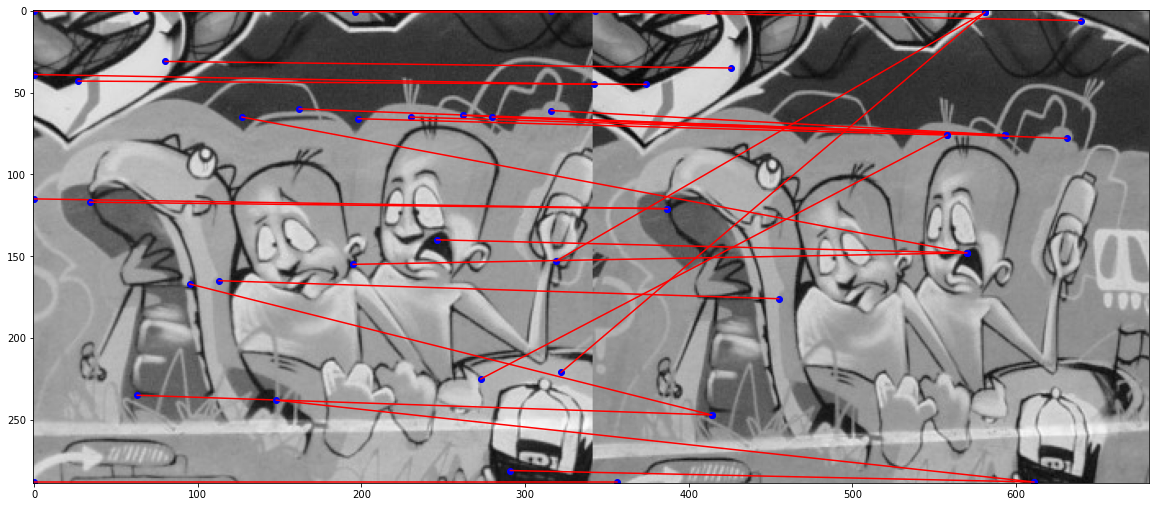

In [13]:
display_matches(graf1_smol, graf2_smol, graf1s_keypt, graf2s_keypt, zip(range(len(graf1s_desc)), graf_cpts))

## c) Function find_matches

In [14]:
def find_correspondances_s(list1, list2):
	c1 = find_correspondances(list1, list2)[:,0]
	c2 = find_correspondances(list2, list1)[:,0]

	indexes = np.arange(len(c1))
	argw = indexes[indexes == c2[c1]]
	return zip(argw, c1[argw])

In [15]:
def find_matches(img1, img2, sigma = 6, threshold = 100):
	_, img1_keypt = harris_feature_detection(img1, sigma, threshold)
	_, img2_keypt = harris_feature_detection(img2, sigma, threshold)

	img1_desc = simple_descriptors(img1, img1_keypt)
	img2_desc = simple_descriptors(img2, img2_keypt)

	return img1_keypt, img2_keypt, find_correspondances_s(img1_desc, img2_desc)

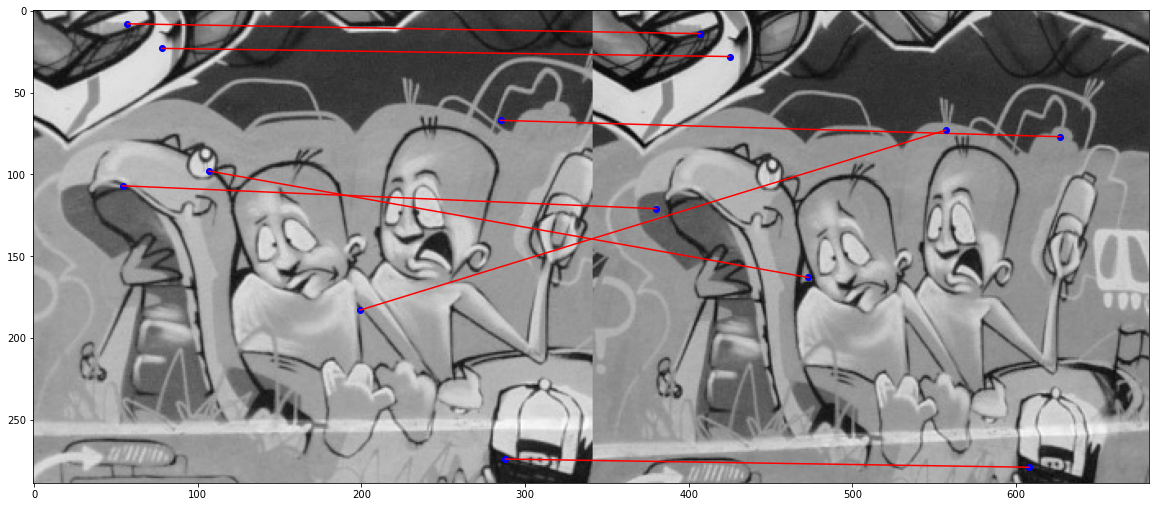

In [20]:
graf1s_keypt, graf2s_keypt, graf_cpts_sym = find_matches(graf1_smol, graf2_smol)
display_matches(graf1_smol, graf2_smol, graf1s_keypt, graf2s_keypt, graf_cpts_sym)

# Exercise 3: Homography estimation

## a) Function estimate_homography

In [17]:
def estimate_homography(r_points, t_points):
	mat = []
	for r,t in zip(r_points, t_points):
		xr, yr = r
		xt, yt = t

		mat.append([xr, yr, 1, 0, 0, 0, -xt * xr, -xt * yr, -xt])
		mat.append([0, 0, 0, xr, yr, 1, -yt * xr, -yt * yr, -yt])
	
	_, _, v = np.linalg.svd(mat)
	h = v.T[:,-1]
	return (h / h[-1]).reshape(3,3)

## b) Testing the homography estimation

In [18]:
img_ny1 = cv2.cvtColor(cv2.imread('data/newyork/newyork1.jpg'), cv2.COLOR_BGR2GRAY)
img_ny2 = cv2.cvtColor(cv2.imread('data/newyork/newyork2.jpg'), cv2.COLOR_BGR2GRAY)

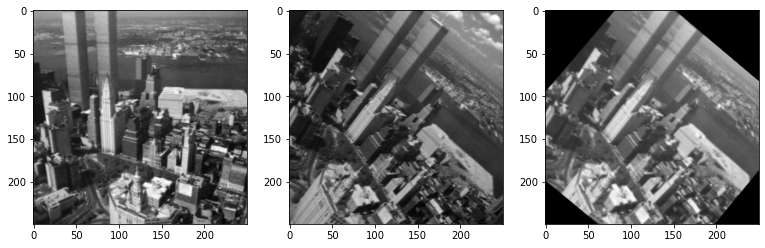

In [41]:
newyork_data = np.array(open('data/newyork/newyork.txt', 'r').read().split()).reshape(4,4)
r_points_ny = np.array(newyork_data[:,0:2]).astype(np.float64)
t_points_ny = np.array(newyork_data[:,2:4]).astype(np.float64)

homo = estimate_homography(r_points_ny, t_points_ny)
warped = cv2.warpPerspective(img_ny1, homo, img_ny1.shape)

plt.figure(figsize=(13, 5))
plt.subplot(1,3,1)
plt.imshow(img_ny1, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img_ny2, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(warped, cmap='gray')

## c) Testing everything

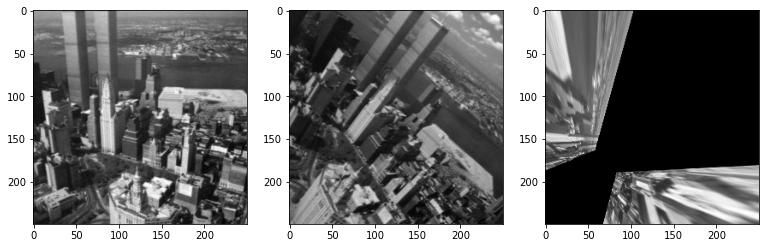

In [47]:
# _, ny1_keypt = harris_feature_detection(img_ny1, 3, 100)
# _, ny2_keypt = harris_feature_detection(img_ny2, 3, 100)
# ny_cpts_sym = find_correspondances(simple_descriptors(img_ny1, ny1_keypt), simple_descriptors(img_ny2, ny2_keypt))
# display_matches(img_ny1, img_ny2, ny1_keypt, ny2_keypt, ny_cpts_sym)

ny1_keypt, ny2_keypt, ny_cpts_sym = find_matches(img_ny1, img_ny2)
# select top 10 best idk how???

# estimate_homography to get H
myhomo_nyc = estimate_homography(ny1_keypt, ny2_keypt)

# cv2.warpPerspective
mywarp_nyc = cv2.warpPerspective(img_ny1, myhomo_nyc, img_ny1.shape)

# display everything
plt.figure(figsize=(13, 5))
plt.subplot(1,3,1)
plt.imshow(img_ny1, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img_ny2, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(mywarp_nyc, cmap='gray')